# Simulation: single ion Rabi with motional heating

In [1]:
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
from tqdm.notebook import tqdm
import torch

## 1. Parameter definitions

### A. User-defined parameters

In [160]:
n_tot = 50               # total number of number state basis to represent the motional state: starts from zero
n_mean_init = 0         # initial mean number of the motional state
spin_down_init = 1      # initial population of spin down

f_Rabi = 50*10**3       # internal state Rabi frequency: units in Hz
lamda = 1/f_Rabi
f_secular = 1.6*10**6   # secular frequency: units in Hz
f_detuning = 0          # detuning: units in Hz
LD_param = 0.1          # Lamb-Dicke parameter: dimensionless
drift_phase = 0

heating_rate = 3000       # heating rate: units in phonons/sec
T_b = 300               # equilibrium temperature of the phonon heat bath: units in Kelvin

t_tot = 1000*1e-6            # total time to simulate: units in sec
dt = 200e-9               # simulation time step: units in sec
t_scale = (10**6)*dt    # plot time scale: units in us

In [161]:
print('Rabi period: {} us'.format(lamda * 1e6))

Rabi period: 20.0 us


In [162]:
if torch.cuda.is_available():
    print('Use ' + torch.cuda.get_device_name())
    dev = 'cuda'
else:
    print('No GPU device is available')
    dev = 'cpu'

Use Tesla T4


### B. Dependent parameters

In [163]:
# returns the mean number of the bath with respect to the motional energy
def return_bath_mean_n():
    hbar = 6.62607015*10**(-34)
    k_B = 1.380649*10**(-23)
    mean_n = 1/(np.exp(hbar*(2*np.pi*f_secular)/(k_B*T_b)) - 1)

    return mean_n

bath_mean_n = return_bath_mean_n()
print('bath mean number: ', round(bath_mean_n))

# returns the coupling efficiency to the bath 
def return_gamma():
    gamma = heating_rate/bath_mean_n

    return gamma

Gamma = return_gamma()
print('Gamma: ', round(Gamma, 6))

# returns the motional decay rate
def return_motional_decay_rate(n):
    decay_rate = Gamma*((2*bath_mean_n + 1)*n + bath_mean_n)/2
    return decay_rate

bath mean number:  621797
Gamma:  0.004825


In [164]:
def get_laguerre(m, n):
    if m == n:
        laguerre_factor = np.exp(-(LD_param**2)/2)*special.genlaguerre(n, 0)(LD_param**2)
    elif m > n:
        n_diff = m- n
        laguerre_coeff = np.exp(-(LD_param**2)/2)*(special.factorial(n)/special.factorial(m))**(1/2)
        laguerre_factor = laguerre_coeff*((1j*LD_param)**n_diff)*special.genlaguerre(n, n_diff)(LD_param**2)
    elif m < n:
        n_diff = n - m
        laguerre_coeff = np.exp(-(LD_param**2)/2)*(special.factorial(m)/special.factorial(n))**(1/2)
        laguerre_factor = laguerre_coeff*((1j*LD_param)**n_diff)*special.genlaguerre(m, n_diff)(LD_param**2)
    return laguerre_factor

def get_laguerre_prime(m, n):
    if m == n:
        laguerre_factor = np.exp(-(LD_param**2)/2)*special.genlaguerre(n, 0)(LD_param**2)
    elif m > n:
        n_diff = m- n
        laguerre_coeff = np.exp(-(LD_param**2)/2)*(special.factorial(n)/special.factorial(m))**(1/2)
        laguerre_factor = laguerre_coeff*((-1j*LD_param)**n_diff)*special.genlaguerre(n, n_diff)(LD_param**2)
    elif m < n:
        n_diff = n - m
        laguerre_coeff = np.exp(-(LD_param**2)/2)*(special.factorial(m)/special.factorial(n))**(1/2)
        laguerre_factor = laguerre_coeff*((-1j*LD_param)**n_diff)*special.genlaguerre(m, n_diff)(LD_param**2)
    return laguerre_factor

## 2. Simulation

In [165]:
# initialize the density matrix elements
sim_init_array = np.zeros((n_tot,n_tot,2,2), dtype=complex)
sim_empty_array = np.zeros((n_tot,n_tot,2,2), dtype=complex)

sim_spin = np.array([[complex(spin_down_init), complex(0)], [complex(0), complex(1 - spin_down_init)]])
sim_spin.reshape(2, 2)
sim_empty = np.array([[complex(0), complex(0)], [complex(0), complex(0)]])
sim_empty.reshape(2, 2)

for n in range(n_tot):
    prob_n = (1/(n_mean_init + 1))*(n_mean_init/(n_mean_init + 1))**n
    sim_init_array[n,n] = prob_n * sim_spin
    
sim_init_array /= sim_init_array.sum()

sim_init_array = torch.from_numpy(sim_init_array).to(dev)
sim_spin = torch.from_numpy(sim_spin).to(dev)
sim_empty = torch.from_numpy(sim_empty).to(dev)

print(sim_init_array[0][0])
print(sim_init_array[n_tot - 1][n_tot - 1])
print(sim_empty_array[0][0])

tensor([[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]], device='cuda:0', dtype=torch.complex128)
tensor([[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]], device='cuda:0', dtype=torch.complex128)
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [166]:
sim_init_array[1,1]

tensor([[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]], device='cuda:0', dtype=torch.complex128)

## Matrix version

In [167]:
# Initial J, Jd matrix --> Constant since there's no time dependencies
J_matrix = np.zeros((n_tot,n_tot), dtype=complex)
J_d_matrix = np.zeros((n_tot,n_tot), dtype=complex)
for m in range(n_tot):
    for n in range(n_tot):        
#         if (m < n_tot - 1) and (n < n_tot - 1):
        J_matrix[m,n] = Gamma*(bath_mean_n + 1)*(((m + 1)*(n + 1))**(1/2))
#         if (1 <= m) and (1 <= n):
        J_d_matrix[m,n] = Gamma*bath_mean_n*((m*n)**(1/2))          

J_matrix = torch.from_numpy(J_matrix).to(dev)
J_d_matrix = torch.from_numpy(J_d_matrix).to(dev)

In [168]:
# Initial K, Kd matrix
K_matrix = np.zeros_like(sim_empty_array, dtype=complex)
K_d_matrix = np.zeros_like(sim_empty_array, dtype=complex)
for m in range(n_tot):
    for n in range(n_tot):
        f_mn = get_laguerre(m,n)
#         f_mn_prime = get_laguerre_prime(m,n)
        f_mn_prime = f_mn.conj()
        K_matrix[m,n] = -(1j/2)*np.array([[0, f_mn * 2*np.pi * f_Rabi], [f_mn_prime * 2*np.pi * f_Rabi, 0]], dtype=complex)    
        K_d_matrix[m,n] = (1j/2)*np.array([[0, f_mn * 2*np.pi * f_Rabi], [f_mn_prime * 2*np.pi * f_Rabi, 0]], dtype=complex) 
        if m == n:
            K_matrix[m,n] -= return_motional_decay_rate(n)*np.eye(2, dtype=complex)
            K_d_matrix[m,n] -= return_motional_decay_rate(n)*np.eye(2, dtype=complex)

K_matrix = torch.from_numpy(K_matrix).to(dev)
K_d_matrix = torch.from_numpy(K_d_matrix).to(dev)

In [169]:
def get_evolved_K(K_mat, K_d_mat):
    # K_mat_dt = np.einsum('ijkl,ijkl->ijkl', K_evolve_matrix, K_mat)
    # K_d_mat_dt = np.einsum('ijkl,ijkl->ijkl', K_evolve_matrix, K_d_mat)
    K_mat_dt = torch.einsum('ijkl,ijkl->ijkl', K_evolve_matrix, K_mat)
    K_d_mat_dt = torch.einsum('ijkl,ijkl->ijkl', K_evolve_matrix, K_d_mat)
    return K_mat_dt, K_d_mat_dt

In [170]:
def get_summed_term(rho_prev, K_mat, K_d_mat):
    # K_term1 = np.einsum('mria,rnaj->mnij', K_mat, rho_prev)
    # K_term2 = np.einsum('mria,rnaj->mnij', rho_prev, K_d_mat)    
    K_term1 = torch.einsum('mria,rnaj->mnij', K_mat, rho_prev)
    K_term2 = torch.einsum('mria,rnaj->mnij', rho_prev, K_d_mat)
    
    rho_n_plus = torch.zeros_like(rho_prev, dtype=torch.complex128)
    rho_n_minus = torch.zeros_like(rho_prev, dtype=torch.complex128)

    rho_n_plus[:-1,:-1] = rho_prev.clone()[1:,1:]
    rho_n_minus[1:,1:] = rho_prev.clone()[:-1,:-1]
    
    # rho_n_plus[:-1,:-1] = torch.roll(rho_prev, shifts=(-1,-1), dims=(0,1))[:-1,:-1]
    # rho_n_minus[1:,1:] = torch.roll(rho_prev, shifts=(1,1), dims=(0,1))[1:,1:]

    # rho_n_plus = np.pad(rho_prev,((0,1),(0,1),(0,0),(0,0)), mode='constant')[1:, 1:] # rho[m+1, n+1]
    # rho_n_minus = np.pad(rho_prev,((1,0),(1,0),(0,0),(0,0)), mode='constant')[:-1, :-1] # rho[m-1, n-1]

    J_term1 = torch.einsum('ij,ijkh->ijkh', J_matrix, rho_n_plus)
    J_term2 = torch.einsum('ij,ijkh->ijkh', J_d_matrix, rho_n_minus)
        
    return K_term1 + K_term2 + J_term1 + J_term2
#     return K_term1 + K_term2
#     return J_term1 + J_term2

In [171]:
transition = 'blue'

if transition == 'blue':
    f_detuning = f_secular
elif transition == 'red':
    f_detuning = -f_secular
else:
    f_detuning = 0

# Evolve K matrix for dt / 2
K_evolve_matrix = np.ones_like(K_matrix.cpu(), dtype=complex)
for m in range(n_tot):
    for n in range(n_tot):
#         K_evolve_matrix[m,n] = np.array([[1, np.exp(1j*((m-n)*f_secular - f_detuning)*dt/2)], 
#                                          [np.exp(-1j*((m-n)*f_secular - f_detuning)*dt/2), 1]])
        K_evolve_matrix[m,n] = np.array([[1, np.exp(1j*2*np.pi*((m-n)*f_secular + f_detuning)*dt/2)], 
                                         [np.exp(1j*2*np.pi*((m-n)*f_secular - f_detuning)*dt/2), 1]])
K_evolve_matrix = torch.from_numpy(K_evolve_matrix).to(dev)
# K_matrix_t = np.zeros((2*int(t_tot/dt), n_tot, n_tot, 2, 2), dtype=complex)
# K_d_matrix_t = np.zeros((2*int(t_tot/dt), n_tot, n_tot, 2, 2), dtype=complex)
# for i in range(int(t_tot/dt)):
#     K_matrix_t[2*i] = K_matrix.copy()
#     K_d_matrix_t[2*i] = K_d_matrix.copy()
#     K_matrix, K_d_matrix = get_evolved_K(K_matrix, K_d_matrix)
    
#     K_matrix_t[2*i+1] = K_matrix.copy()
#     K_d_matrix_t[2*i+1] = K_d_matrix.copy()

In [172]:
sim_timeline = {'time_step' : list(), 'prob_up' : list(), 'rho_hist': []}

traced = sim_init_array.sum(axis=(0,1))
prob_up = traced[1][1].real
sim_timeline['time_step'].append(0)      # plot units in us
sim_timeline['prob_up'].append(prob_up.cpu().detach().numpy())

# update density matrix elements
sim_prev = cp.deepcopy(sim_init_array)
sim_next = cp.deepcopy(sim_empty_array)
sim_timeline['rho_hist'].append(sim_prev.clone().cpu().detach().numpy())

time = 0
for it in tqdm(range(round(t_tot/dt))): 
#     K_matrix, K_d_matrix = get_evolved_K(K_matrix, K_d_matrix)
#     K_matrix, K_d_matrix = get_evolved_K(K_matrix, K_d_matrix)
#     summed = get_summed_term(sim_prev, K_matrix, K_d_matrix)
    
#     sim_next = sim_prev + summed * dt
    

    summed = get_summed_term(sim_prev, K_matrix, K_d_matrix)
    k1 = summed * dt
    
    K_matrix, K_d_matrix = get_evolved_K(K_matrix, K_d_matrix)
#     K_matrix, K_d_matrix = K_matrix_t[2*it], K_d_matrix_t[2*it] 
    summed = get_summed_term(sim_prev + k1/2, K_matrix, K_d_matrix)
    k2 = summed * dt
    summed = get_summed_term(sim_prev + k2/2, K_matrix, K_d_matrix)
    k3 = summed * dt
    
    K_matrix, K_d_matrix = get_evolved_K(K_matrix, K_d_matrix)
#     K_matrix, K_d_matrix = K_matrix_t[2*it+1], K_d_matrix_t[2*it+1] 
    summed = get_summed_term(sim_prev + k3, K_matrix, K_d_matrix)
    k4 = summed * dt
    
    sim_next = sim_prev + (k1 + 2*k2 + 2*k3 + k4)/6
#     sim_next /= sim_next.sum(axis=(0,1))[0,0] + sim_next.sum(axis=(0,1))[1,1]
    
    traced = sim_next.sum(axis=(0,1))
    prob_up = traced[1][1].real
    
    sim_timeline['time_step'].append((it+1)*t_scale)      # plot units in us
    sim_timeline['prob_up'].append(prob_up.cpu().detach().numpy())
    sim_timeline['rho_hist'].append(sim_next.clone().cpu().detach().numpy())
    
    sim_prev = cp.deepcopy(sim_next)
    sim_next = cp.deepcopy(sim_empty_array)

sim_final_array = cp.deepcopy(sim_prev)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [173]:
for i in range(len(sim_timeline['rho_hist'])):
    sim_timeline['rho_hist'][2].sum(axis=(0,1))

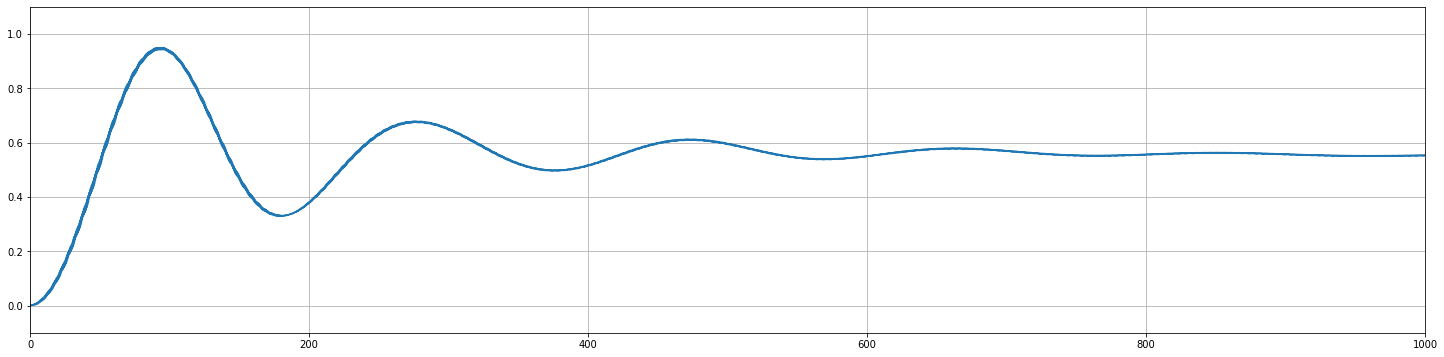

In [174]:
plt.rcParams['figure.figsize'] = (25,6)
plt.grid()
plt.xlim(0, sim_timeline['time_step'][-1])
plt.ylim(-0.1, 1.1)
plt.plot(sim_timeline['time_step'][:], sim_timeline['prob_up'][:])

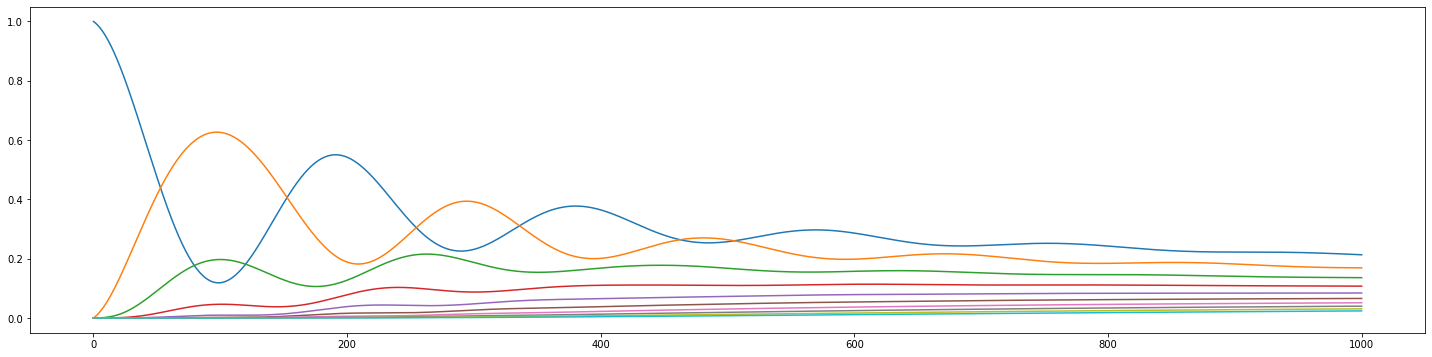

In [175]:
for n in range(10):
    plt.plot(sim_timeline['time_step'], 
             [np.diag(sim_timeline['rho_hist'][i][n,n]).sum().real for i in range(len(sim_timeline['rho_hist']))])